In [281]:
# from numpy import cov
import os
import pandas
import geopandas
from shapely.geometry import Point
import sys
# from pytesmo.time_series.anomaly import calc_anomaly
# from pytesmo.time_series.anomaly import calc_anomaly
sys.path.append('../python')
sys.path.append('../../icos_data')
sys.path.append('../../ismn_data\HOBE_Data_2015-2018')
import sm_config as config
import sm_tools as tools
import sm_triplecollocation

In [282]:
def get_filenames(path_to_dir, suffix=".csv"):
    filenames = os.listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith(suffix) ]

In [283]:
# Index(['ref_dataset', 'eval_dataset', 'timefilter', 'anomaly', 'loc', 'lon',
#        'lat', 'veg_class', 'pearson_r', 'pearson_r_p-value', 'bias', 'rmsd',
#        'ubrmsd', 'n', 'pearson_sig'],
def get_plot(dataframe, metric_col, plot_name, sig=None, anomaly=True, timefilter="all", veg_class_filter=None, lon_field="lon", lat_field="lat"):
    plot = ""
    return plot
    

In [284]:
map_output_dir = r"../analysis_output/grid_evaluation_maps"
if not os.path.exists(map_output_dir):
    os.mkdir(map_output_dir)

In [285]:
# import pandas as pd
# import geopandas
# from shapely.geometry import Point
# import matplotlib.pyplot as plt

# df = pd.read_csv('name.csv')

# geometry = [Point(xy) for xy in zip(df.iloc[:, 0], df.iloc[:, 1])]

# gdf = geopandas.GeoDataFrame(df, geometry=geometry)

# gdf.plot(column=' Ref')

# plt.savefig('raster.tiff')

In [286]:
# "C:\git\soil-moisture-sweden\analysis_output\ERA5 0-1 grid evaluation 20210407124502"
grid_metrics_dir = r"../analysis_output/ERA5 0-1 grid evaluation 20210407124502"
print(grid_metrics_dir)
os.getcwd()
os.listdir(grid_metrics_dir)

../analysis_output/ERA5 0-1 grid evaluation 20210407124502


['ASCAT 12.5 TS ERA5 0-1 absolute',
 'ASCAT 12.5 TS ERA5 0-1 anomaly',
 'ASCAT 12.5 TS metrics.csv',
 'CCI Active ERA5 0-1 absolute',
 'CCI Active ERA5 0-1 anomaly',
 'CCI Active metrics.csv',
 'CCI Combined ERA5 0-1 absolute',
 'CCI Combined ERA5 0-1 anomaly',
 'CCI Combined metrics.csv',
 'CCI Passive ERA5 0-1 absolute',
 'CCI Passive ERA5 0-1 anomaly',
 'CCI Passive metrics.csv',
 'GLDAS ERA5 0-1 absolute',
 'GLDAS ERA5 0-1 anomaly',
 'GLDAS metrics.csv',
 'Sentinel-1 ERA5 0-1 absolute',
 'Sentinel-1 ERA5 0-1 anomaly',
 'Sentinel-1 metrics.csv',
 'SMAP L3 Enhanced ERA5 0-1 absolute',
 'SMAP L3 Enhanced ERA5 0-1 anomaly',
 'SMAP L3 Enhanced metrics.csv',
 'SMAP L3 ERA5 0-1 absolute',
 'SMAP L3 ERA5 0-1 anomaly',
 'SMAP L3 metrics.csv',
 'SMAP L4 ERA5 0-1 absolute',
 'SMAP L4 ERA5 0-1 anomaly',
 'SMAP L4 metrics.csv',
 'SMOS-BEC ERA5 0-1 absolute',
 'SMOS-BEC ERA5 0-1 anomaly',
 'SMOS-BEC metrics.csv',
 'SMOS-IC ERA5 0-1 absolute',
 'SMOS-IC ERA5 0-1 anomaly',
 'SMOS-IC metrics.csv']

In [287]:
grid_metrics_csvs = get_filenames(grid_metrics_dir)
print(grid_metrics_csvs)

['ASCAT 12.5 TS metrics.csv', 'CCI Active metrics.csv', 'CCI Combined metrics.csv', 'CCI Passive metrics.csv', 'GLDAS metrics.csv', 'Sentinel-1 metrics.csv', 'SMAP L3 Enhanced metrics.csv', 'SMAP L3 metrics.csv', 'SMAP L4 metrics.csv', 'SMOS-BEC metrics.csv', 'SMOS-IC metrics.csv']


In [288]:
for fn in grid_metrics_csvs[0:1]:
    pn = fn.replace(" metrics.csv", "")
    print(pn)
    f = os.path.join(grid_metrics_dir, fn)
    df = pandas.read_csv(f)
#     print(df)
    print(df.columns)
#     print([df.timefilter.unique()])
    # filter df by timefilter values
    # filter out insignificant and non-anomaly rows
    df_sub = df[(df.pearson_sig == True) & (df.anomaly == True)]
    for timefilter in df.timefilter.unique():
        if timefilter != "all":
            df_tf = df_sub[df.timefilter == timefilter]
#             print(df_tf)
            print(timefilter)
            print(df_tf.shape)
            # create and output map
        # lon = col 5, lat = col 6
            geometry = [Point(xy) for xy in zip(df.iloc[:, 5], df.iloc[:, 6])]
            gdf = geopandas.GeoDataFrame(df, geometry=geometry)
#             gdf.plot(column='pearson_r', legend=True)
            if timefilter == "No-Timefilter":
                for veg_class in df.veg_class.unique():
                    if veg_class not in config.ignore_veg_classes:
                        df_vc = df_tf[df_tf.veg_class == veg_class]
#                         print(veg_class)
#                         print(df_vc.shape)
                        # create and output map
#     print(df.timefilter.unique()) 
#     print(df)
#     geometry = [Point(xy) for xy in zip(df.iloc[:, 0], df.iloc[:, 1])]

ASCAT 12.5 TS
Index(['ref_dataset', 'eval_dataset', 'timefilter', 'anomaly', 'loc', 'lon',
       'lat', 'veg_class', 'pearson_r', 'pearson_r_p-value', 'bias', 'rmsd',
       'ubrmsd', 'n', 'pearson_sig'],
      dtype='object')
No-Timefilter
(900, 15)
Y2015
(967, 15)
Y2016
(765, 15)
Y2017
(981, 15)
Y2018
(972, 15)
winter
(1101, 15)
spring
(1035, 15)
summer
(1184, 15)
fall
(1217, 15)


C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Y2015-winter
(872, 15)
Y2016-winter
(1033, 15)
Y2017-winter
(818, 15)
Y2018-winter
(1143, 15)
Y2015-spring
(1036, 15)
Y2016-spring
(849, 15)
Y2017-spring
(823, 15)
Y2018-spring
(947, 15)
Y2015-summer
(1151, 15)
Y2016-summer
(1177, 15)
Y2017-summer
(1045, 15)
Y2018-summer
(893, 15)
Y2015-fall
(1212, 15)
Y2016-fall
(1213, 15)
Y2017-fall
(1217, 15)
Y2018-fall
(1209, 15)
M01
(1052, 15)
M02
(1087, 15)
M03
(995, 15)
M04
(1052, 15)
M05
(605, 15)
M06
(1122, 15)
M07
(1200, 15)
M08
(1208, 15)
M09
(1215, 15)
M10
(1217, 15)
M11
(1212, 15)
M12
(897, 15)
Y2015-M01
(895, 15)
Y2016-M01
(788, 15)
Y2017-M01
(669, 15)
Y2018-M01
(777, 15)
Y2015-M02
(728, 15)
Y2016-M02
(822, 15)
Y2017-M02
(851, 15)
Y2018-M02
(437, 15)
Y2015-M03
(733, 15)
Y2016-M03
(877, 15)
Y2017-M03
(875, 15)
Y2018-M03
(776, 15)
Y2015-M04
(893, 15)
Y2016-M04
(814, 15)
Y2017-M04
(863, 15)
Y2018-M04
(984, 15)
Y2015-M05
(984, 15)
Y2016-M05
(874, 15)
Y2017-M05
(617, 15)
Y2018-M05
(737, 15)
Y2015-M06
(833, 15)
Y2016-M06
(1065, 15)
Y2017-M06
(8

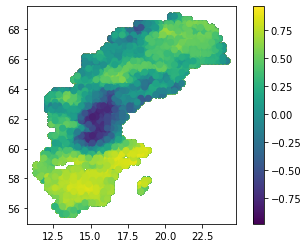

In [289]:
# lon = col 5, lat = col 6
geometry = [Point(xy) for xy in zip(df.iloc[:, 5], df.iloc[:, 6])]
gdf = geopandas.GeoDataFrame(df, geometry=geometry)
gdf.plot(column='pearson_r', legend=True)

In [290]:
# import os
# import gdal

# dir_with_csvs = r"/home/panda"
# os.chdir(dir_with_csvs)

# def find_csv_filenames(path_to_dir, suffix=".csv"):
#     filenames = os.listdir(path_to_dir)
#     return [ filename for filename in filenames if filename.endswith(suffix) ]
# csvfiles = find_csv_filenames(dir_with_csvs)
# for fn in csvfiles:
#     vrt_fn = fn.replace(".csv", ".vrt")
#     lyr_name = fn.replace('.csv', '')
#     out_tif = fn.replace('.csv', '.tiff')
#     with open(vrt_fn, 'w') as fn_vrt:
#         fn_vrt.write('<OGRVRTDataSource>\n')
#         fn_vrt.write('\t<OGRVRTLayer name="%s">\n' % lyr_name)
#         fn_vrt.write('\t\t<SrcDataSource>%s</SrcDataSource>\n' % fn)
#         fn_vrt.write('\t\t<GeometryType>wkbPoint</GeometryType>\n')
#         fn_vrt.write('\t\t<GeometryField encoding="PointFromColumns" x="Lon" y="Lat" z="Ref"/>\n')
#         fn_vrt.write('\t</OGRVRTLayer>\n')
#         fn_vrt.write('</OGRVRTDataSource>\n')

# output = gdal.Grid('outcome.tif','name.vrt')
# # below using your settings - I don't have sample large enough to properly test it, but it is generating file as well  
# output2 = gdal.Grid('outcome2.tif','name.vrt', algorithm='invdist:power=2.0:smoothing=1.0')  